<a href="https://colab.research.google.com/github/Ariara61/ESAA/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C_452~465.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06 군집화 실습 - 고객 세그먼테이션
**고객 세그먼테이션의 정의와 기법**
* 고객 세그먼테이션(Customer Segmentation): 다양한 기준으로 고객을 분류하는 기법. CRM이나 마케팅의 중요 기반 요소
* 고객의 중요한 분류 요소는 어떤 상품을 얼마나 많은 비용을 써서 얼마나 자주 사용하는지에 기반한 정보로 분류하는 것이 보통임.
* 타깃 마케팅: 고객을 여러 특성에 맞게 세분화해서 그 유형에 따라 맞춤형 마케팅이나 서비를 제공하는 것
* 고객 세그먼테이션은 고객의 어떤 요소를 기반으로 군집화할 것인가를 결정하는 것이 중요한데, 기본적인 고객 분석 요소인 RFM 기법을 이용
* RFM 기법
 * Reccency(R): 가장 최근 상품 구입 일에서 오늘까지의 기간
 * Frequency(F): 상품 구매 횟수
 * Monetary Value(M): 총 구매 금액

**데이터 세트 로딩과 데이터 클렌징**


In [1]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

retail_df = pd.read_excel(io = "Online Retail.xlsx")
retail_df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


* 칼럼
 * InvoiceNo: 주문번호
 * StockCode: 제품 코드
 * Description: 제품 설명
 * Quantity: 주문 제품 건수
 * InvoiceDate: 주문 일자
 * UnitPrice: 제품 단가
 * CustomerID: 고객 번호
 * Country: 국가명

In [2]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


* Null 제거: CustomerID의 Null 값이 너무 많음
* 오류 데이터 삭제: Quantity 또는 UnitPrice가 0보다 작은 경우

In [3]:
retail_df = retail_df[retail_df["Quantity"] > 0]
retail_df = retail_df[retail_df["UnitPrice"] > 0]
retail_df = retail_df[retail_df["CustomerID"].notnull()]
print(retail_df.shape)
retail_df.isnull().sum()

(397884, 8)


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [4]:
retail_df["Country"].value_counts()[:5]

United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Name: Country, dtype: int64

* 영국이 대다수를 차지하므로 다른 국가의 데이터는 모두 제외

In [5]:
retail_df = retail_df[retail_df["Country"] == "United Kingdom"]
print(retail_df.shape)

(354321, 8)


**RFM 기반 데이터 가공**
* "UnitPrice"와 "Quantity"를 곱해서 주문 금액 데이터 만들기
* CustomerNo도 더 편리한 식별성을 위해 float 형을 int 형으로 변경

In [6]:
retail_df["sale_amount"] = retail_df["Quantity"] * retail_df["UnitPrice"]
retail_df["CustomerID"] = retail_df["CustomerID"].astype(int)

<ipython-input-6-c9a4a63ac1e3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retail_df["sale_amount"] = retail_df["Quantity"] * retail_df["UnitPrice"]
<ipython-input-6-c9a4a63ac1e3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retail_df["CustomerID"] = retail_df["CustomerID"].astype(int)


* Top-5 주문 건수와 주문 금액을 가진 고객 데이터를 추출

In [7]:
print(retail_df["CustomerID"].value_counts().head(5))
print(retail_df.groupby("CustomerID")["sale_amount"].sum().sort_values(ascending = False)[:5])

17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: CustomerID, dtype: int64
CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: sale_amount, dtype: float64


In [8]:
retail_df.groupby(["InvoiceNo", "StockCode"])["InvoiceNo"].count().mean()

1.028702077315023

* RFM 기반의 고객 세그먼테이션은 고객 레벨로주문 기간, 주문 횟수, 주문 금액 데이터를 기반으로 해 세그먼테이션을 수행하기 때문에 주문번호 + 상품코드 기준의 데이터를 고객 기준의 Recency, Frequency, Monetary value로 변경해야 함.
* DataFrame의 groupby()만 사용해서는 여러 개의 칼럼에 서로 다른 aggregation 연산을 한 번에 수행하기 어려움
* 이를 해결하기 위해서 DataFrame에 groupby를 호출해 반환된 DataFrameGroupby 객체에 agg()을 이용함
* agg()에 인자로 대상 칼럼들과 aggregation 함수명들을 딕셔너리 형태로 입력하면 칼럼 여러 개의 서로 다른 aggregation을 쉽게 수행할 수 있음


In [9]:
# DataFrame의 groupby()의 multiple 연산을 위해 agg() 이용
# Recency는 InvoiceData 칼럼의 max()에서 데이터 가공
# Frequency는 InvoiceNo 칼럼의 count(), Monetary value는 sale_amount 칼럼의 sum()
aggregations = {
    "InvoiceDate": "max",
    "InvoiceNo": "count",
    "sale_amount": "sum"
}
cust_df = retail_df.groupby("CustomerID").agg(aggregations)
# groupby된 결과 칼럼 값을 Recency, Frequency, Monetary로 변경
cust_df = cust_df.rename(columns = {"InvoiceDate": "Recency",
                                    "InvoiceNo": "Frequency",
                                    "sale_amount": "Monetary"
                                    }
)
cust_df = cust_df.reset_index()
cust_df.head(3)

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73


* Recency는 고객이 가장 최근에 주문한 날짜를 기반으로 하는데, 오늘 날짜를 기준으로 가장 최근 주문 일자를 뺀 날짜
* 오늘 날짜를 현재 날짜로 해서는 안 됨

In [10]:
import datetime as dt

cust_df["Recency"] = dt.datetime(2011, 12, 10) - cust_df["Recency"]
cust_df["Recency"] = cust_df["Recency"].apply(lambda x: x.days + 1)
print("cust_df 로우와 칼럼 건수는 ", cust_df.shape)
cust_df.head(3)

cust_df 로우와 칼럼 건수는  (3920, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73


**RFM 기반 고객 세그먼테이션**
* 온라인 판매 데이터 세트는 소매업체의 대규모 주문을 포함하고 있음
* 이들은 주문 횟수와 주문 금액에서 개인 고객 주문과 매우 큰 차이를 나타내고 있으며 이로 인해 매우 왜곡된 데이터 분포도를 가지게 되어 군집화가 한쪽 군집에만 집중되는 현상이 발생.

(array([3.887e+03, 1.900e+01, 9.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([3.75000000e+00, 2.59691050e+04, 5.19344600e+04, 7.78998150e+04,
        1.03865170e+05, 1.29830525e+05, 1.55795880e+05, 1.81761235e+05,
        2.07726590e+05, 2.33691945e+05, 2.59657300e+05]),
 <BarContainer object of 10 artists>)

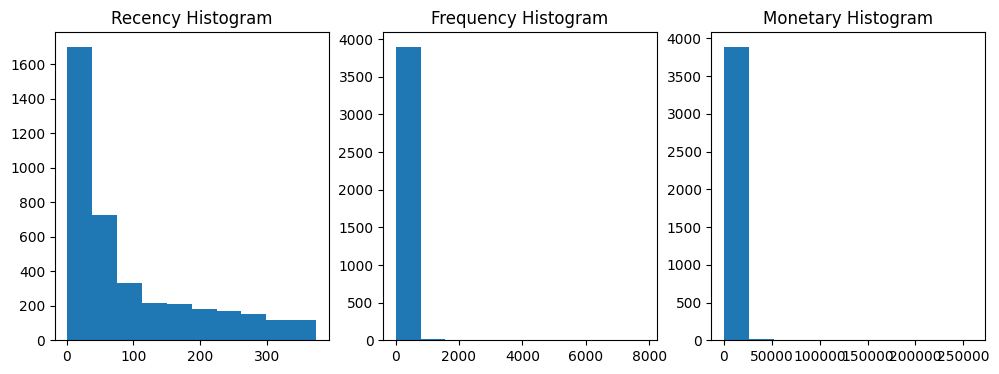

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize = (12, 4), nrows = 1, ncols = 3)
ax1.set_title("Recency Histogram")
ax1.hist(cust_df["Recency"])

ax2.set_title("Frequency Histogram")
ax2.hist(cust_df["Frequency"])

ax3.set_title("Monetary Histogram")
ax3.hist(cust_df["Monetary"])

* Recency, Frequency, Monetary 모두 왜곡된 데이터 값 분포도를 가지고 있으며, 특히 Frequency, Monetary의 경우 특정 범위에 값이 몰려 있어서 왜곡 정도가 매우 심함

In [12]:
cust_df[["Recency", "Frequency", "Monetary"]].describe()

,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,92.742092,90.388010,1864.385601
std,99.533485,217.808385,7482.817477
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,300.280000
50%,51.000000,41.000000,652.280000
75%,143.000000,99.250000,1576.585000
max,374.000000,7847.000000,259657.300000


* 왜곡 정도가 매우 높은 데이터 세트에 K-평균 군집을 적용하면 중심의 개수가 증가시키더라도 변별력이 떨어지는 군집화가 수행됨.

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X_features = cust_df[["Recency", "Frequency", "Monetary"]].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters = 3, random_state = 0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df["cluster_label"] = labels

print("실루엣 스코어는: {0:.3f}".format(silhouette_score(X_features_scaled, labels)))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


실루엣 스코어는: 0.592


* 군집을 3개로 구성할 경우 전체 군집의 평균 실루엣 계수인 실루엣 스코어는 0.592로 안정적인 수치가 나옴

In [17]:
import matplotlib.cm as cm

def visualize_silhouette(cluster_lists, X_features):

    # 입력값으로 클러스 터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

In [20]:
def visualize_kmeans_plot_multi(cluster_lists, X_features):

    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np

    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])

     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장.
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels

        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']

        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))
        axs[ind].legend(loc='upper right')

    plt.show()

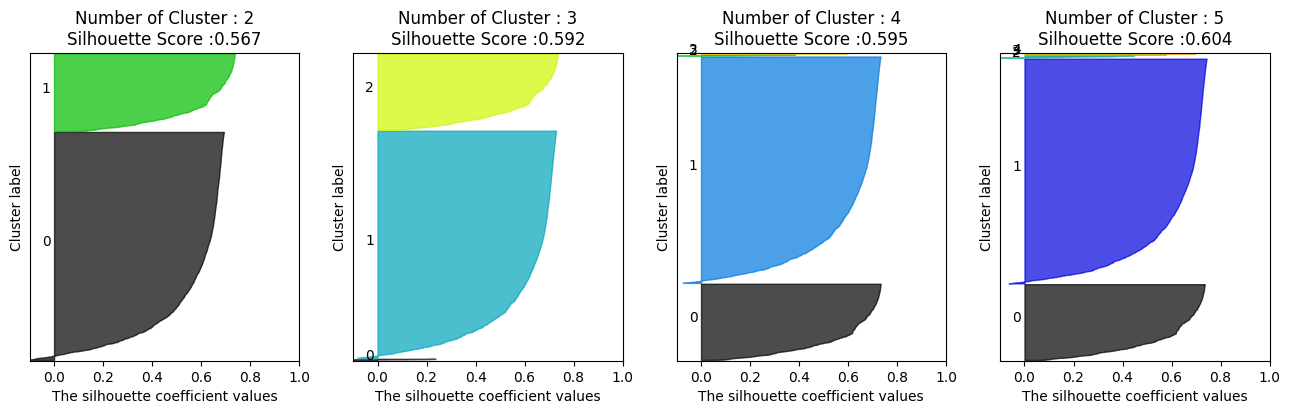

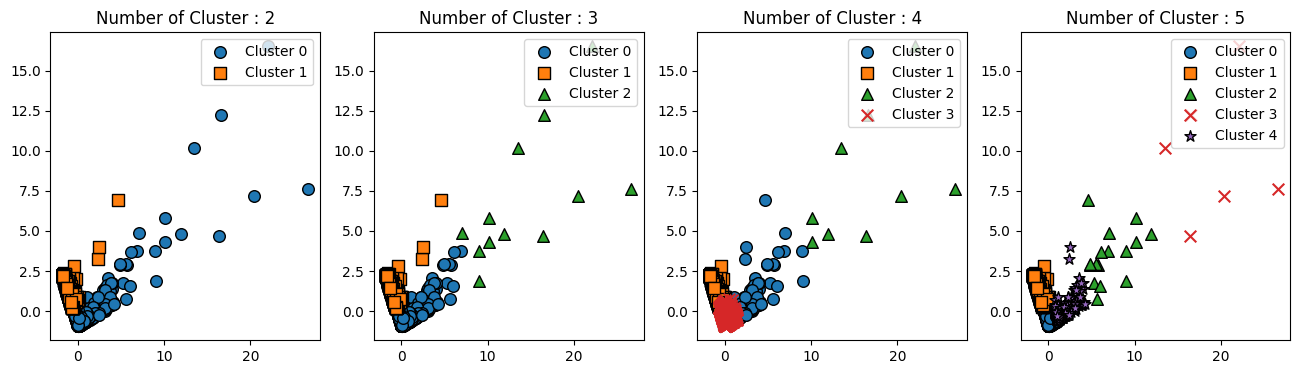

In [21]:
import warnings
warnings.filterwarnings("ignore")

visualize_silhouette([2, 3, 4, 5], X_features_scaled)
visualize_kmeans_plot_multi([2, 3, 4, 5], X_features_scaled)

* 군집이 2개일 경우
 * 0번 군집과 1번 군집이 너무 개괄적으로 군집화 됨

* 군집이 3개 이상일 경우
 * 데이터 세트의 개수가 너무 작은 군집이 만들어짐
 * 또한 군집 내부에서도 데이터가 광범위하게 퍼져 있음

* 데이터 세트의 왜곡 정도를 낮추기 위해 가장 자주 사용되는 방법은 데이터 값에 로그(log)를 적용하는 로그 변환

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Recency, Frequency, Monetary 칼럼에 np.log1p()로 Log Transformation
cust_df["Recency_log"] = np.log1p(cust_df["Recency"])
cust_df["Frequency_log"] = np.log1p(cust_df["Frequency"])
cust_df["Monetary_log"] = np.log1p(cust_df["Monetary"])

# Log Trnasformation 데이터에 StandardScaler 적용
X_features = cust_df[["Recency_log", "Frequency_log", "Monetary_log"]].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters = 3, random_state = 0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df["cluster_label"] = labels

print("실루엣 스코어는: {0:.3f}".format(silhouette_score(X_features_scaled, labels)))

실루엣 스코어는: 0.303


* 실루엣 스코어는 로그 변환하기 전보다 떨어짐
* 하지만 실루엣 스코어의 절대치가 중요한 것이 아니며, 어떻게 개별 군집이 더 균일하게 나뉠 수 있는지가 더 중요

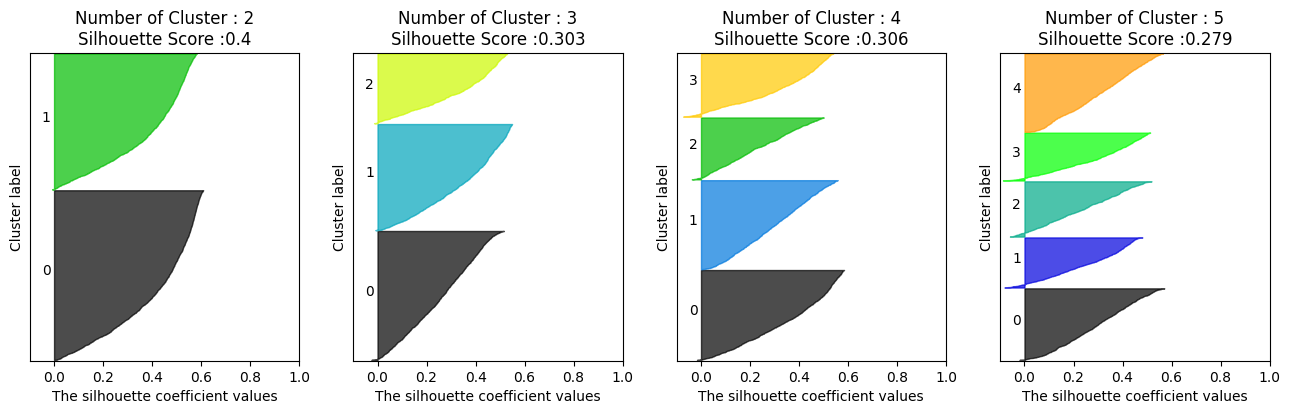

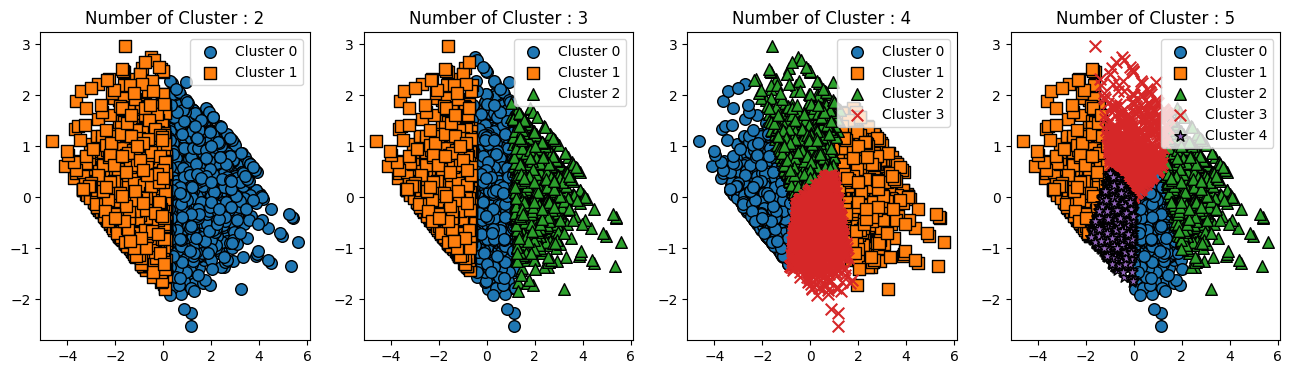

In [24]:
visualize_silhouette([2, 3, 4, 5], X_features_scaled)
visualize_kmeans_plot_multi([2, 3, 4, 5], X_features_scaled)

* 실루엣 스코어는 로그 변환하기 전보다 떨어지지만 앞의 경우보다 더 균일하게 군집화가 구성됐음을 위 그림을 통해 알 수 이씅ㅁ

# 07 정리
* 각 군집화 기법은 나름의 장/단점을 가지고 있으며, 군집화하려는 데이터의 특성에 맞게 선택해야 함
* K-평균
 * 거리 기반으로 군집 중심점을 이동시키면서 군집화를 수행
 * 매우 쉽고 직관적인 알고리즘으로 많은 군집화 애플리케이션에서 애용되지만, 복잡한 구조를 가지는 데이터 세트에 적용하기에는 한계가 있으며, 군집화 개수를 최적화하기가 어려움
 * 군집이 잘 되었는지의 평가를 위해 실루엣 계수를 이용
* 평균 이동(Mean Shift)
 * K-평균과 유사하지만 거리 중심이 아니라 데이터가 모여 있는 밀도가 가장 높은 쪽으로 군집 중심점을 이동하면서 군집화를 수행
 * 일반 업부 기반의 정형 데이터 세트보다는 컴퓨터 비전 영역에서 이미지나 영상 데이터에서 특정 개체를 구분하거나 움직임을 추적하는 데 뛰어난 역할을 수행하는 알고리즘
* GMM(Gaussian Mixture Model) 군집화
 * 군집화를 적용하고자 하는 데이터가 여러 개의 가우시안 분포(Gaussian Distribution)를 모델을 섞어서 생성된 모델로 가정해 수행하는 방식
 * 전체 데이터 세트에서 서로 다른 정규 분포 형태를 추출해 이렇게 다른 정규 분포를 가진 데이터 세트를 각각 군집화하는 것
 * K-평균보다 유연하게 다양한 데이터 세트에 잘 적용된 수 있다는 장점과 군집화를 위한 수행 시간이 오래 걸린다는 단점이 있음
* DBSCAN
 * 밀도 기반 군집화의 대표적인 알고리즘
 * 입실론 주변 영역 내에 포함되는 최소 데이터 개수의 충족 여부에 따라 데이터 포인트를 핵심 포인트, 아웃 포인트, 경계 포인트, 잡음 포인트로 구분하고 특정 핵심 포인트에서 직접 접근이 가능한 다른 핵심 포인트를 서로 연결하면서 군집화를 구성하는 방식
 * 간단하고 직관적인 알고리즘으로 돼 있음에도 데이터의 분포가 기하학적으로 복잡한 데이터 세트에도 효과적인 군집화가 가능